In [2]:
import pandas as pd
from datetime import datetime
import plotly.express as px

In [3]:
# https://www.data.go.kr/data/15049591/fileData.do <= 표준산업분류코드 데이터
def std_convert(str):
    return f"0{str}" if len(str) == 1 else str
STD_TOBZ_M_df = pd.read_csv("dataset/고용노동부_표준산업분류코드.csv")
STD_TOBZ_M_df['고용업종코드(중분류)'] = STD_TOBZ_M_df['고용업종코드(중분류)'].astype(int).astype(str)
STD_TOBZ_M_df['고용업종코드(중분류)'] = STD_TOBZ_M_df['고용업종코드(중분류)'].apply(lambda x : std_convert(x))
STD_TOBZ_M_df['고용업종코드(소분류)'] = STD_TOBZ_M_df['고용업종코드(소분류)'].astype(str)

STD_TOBZ_M_dic = dict(zip(STD_TOBZ_M_df['고용업종코드(중분류)'], STD_TOBZ_M_df['고용업종명(중분류)'])) # 표준산업분류 - 중분류 dict
STD_TOBZ_S_dic = dict(zip(STD_TOBZ_M_df['고용업종코드(소분류)'], STD_TOBZ_M_df['고용업종명(소분류)'])) # 표준산업분류 - 소분류 dict

In [4]:
MAPBOX_API_KEY = "pk.eyJ1IjoiZGRhbGFkZHVsYSIsImEiOiJjbHNsMDIxMTIwNHk1MmttemI1azlhdTd1In0.Zr3dn9eBHjGgV0AQwjfEBw"

In [5]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

In [10]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
shp_file_path = "dataset/_census_data_2023_bnd_dong_bnd_dong_11020_2023_2023/bnd_dong_11020_2023_2023_2Q.shp"
# shp 파일을 GeoDataFrame으로 읽기
gdf = gpd.read_file(shp_file_path, encoding="UTF8").to_crs(epsg=4326)
gdf

,BASE_DATE,ADM_NM,ADM_CD,geometry
0,20230701,중림동,11020680,"POLYGON ((126.97001 37.56197, 126.97003 37.561..."
1,20230701,장충동,11020580,"POLYGON ((127.00717 37.56372, 127.00713 37.563..."
2,20230701,광희동,11020590,"POLYGON ((127.01001 37.56932, 127.01001 37.569..."
3,20230701,을지로동,11020600,"POLYGON ((127.00332 37.56963, 127.00352 37.569..."
4,20230701,소공동,11020520,"POLYGON ((126.97571 37.56925, 126.97573 37.569..."
5,20230701,회현동,11020540,"POLYGON ((126.98157 37.56113, 126.98185 37.560..."
6,20230701,명동,11020550,"POLYGON ((126.97644 37.56932, 126.97644 37.569..."
7,20230701,필동,11020570,"POLYGON ((126.99145 37.56328, 126.99151 37.563..."
8,20230701,신당5동,11020650,"POLYGON ((127.02113 37.56561, 127.02112 37.565..."
9,20230701,황학동,11020670,"POLYGON ((127.02314 37.57196, 127.02336 37.571..."


In [75]:
# GeoJSON으로 저장
output_geojson_path = 'dataset/nj_df.geojson'
gdf.to_file(output_geojson_path, driver='GeoJSON')

In [11]:
import json
# GeoJSON 파일을 읽기 모드로 열고 데이터를 로드
with open('dataset/jg.geojson', 'r', encoding="UTF8") as f:
    geojson_data = json.load(f)

In [12]:
df = gpd.read_file('dataset/jg.geojson')
df.head()

,BASE_DATE,ADM_NM,ADM_CD,geometry
0,20230701,중림동,11020680,"POLYGON ((126.97001 37.56197, 126.97003 37.561..."
1,20230701,장충동,11020580,"POLYGON ((127.00717 37.56372, 127.00713 37.563..."
2,20230701,광희동,11020590,"POLYGON ((127.01001 37.56932, 127.01001 37.569..."
3,20230701,을지로동,11020600,"POLYGON ((127.00332 37.56963, 127.00352 37.569..."
4,20230701,소공동,11020520,"POLYGON ((126.97571 37.56925, 126.97573 37.569..."


In [13]:
gdf = pd.json_normalize(geojson_data['features'])
gdf

,type,properties.BASE_DATE,properties.ADM_NM,properties.ADM_CD,geometry.type,geometry.coordinates
0,Feature,20230701,중림동,11020680,Polygon,"[[[126.97000579206278, 37.561973717445014], [1..."
1,Feature,20230701,장충동,11020580,Polygon,"[[[127.0071663660531, 37.56371518889506], [127..."
2,Feature,20230701,광희동,11020590,Polygon,"[[[127.01000841970331, 37.56932071725741], [12..."
3,Feature,20230701,을지로동,11020600,Polygon,"[[[127.00331998423667, 37.569628041244655], [1..."
4,Feature,20230701,소공동,11020520,Polygon,"[[[126.97571046689632, 37.56924634170019], [12..."
5,Feature,20230701,회현동,11020540,Polygon,"[[[126.98156612092468, 37.561130394620264], [1..."
6,Feature,20230701,명동,11020550,Polygon,"[[[126.97644092274696, 37.56932338569586], [12..."
7,Feature,20230701,필동,11020570,Polygon,"[[[126.99145018675533, 37.56327940446106], [12..."
8,Feature,20230701,신당5동,11020650,Polygon,"[[[127.02112728877367, 37.56561462904592], [12..."
9,Feature,20230701,황학동,11020670,Polygon,"[[[127.02313682540294, 37.57196080915368], [12..."


In [14]:
NM_dic = dict(zip(jg_df['city_s'].value_counts().index, jg_df['city_s'].value_counts().values))
NM_dic

{'약수동': 25382,
 '청구동': 23383,
 '다산동': 23374,
 '황학동': 23308,
 '동화동': 22564,
 '중림동': 22328,
 '신당동': 20917,
 '신당5동': 20805,
 '광희동': 19637,
 '회현동': 17965,
 '명동': 17712,
 '필동': 17290,
 '장충동': 16702,
 '소공동': 16297,
 '을지로동': 14425}

In [15]:
gdf['Counts'] = gdf['properties.ADM_NM'].map(NM_dic)
gdf['Scaling_Counts'] = (gdf['Counts'] - gdf['Counts'].min()) / (gdf['Counts'].max() - gdf['Counts'].min())
#gdf['geometry.coordinates'] = gdf['geometry.coordinates'].apply(lambda x : x[0])
gdf = gdf.rename(columns={'geometry.coordinates':'coordinates'})
gdf['city_s'] = gdf['properties.ADM_NM'].copy()
gdf = gdf.iloc[:,5:].reset_index(drop=True)
gdf

,coordinates,Counts,Scaling_Counts,city_s
0,"[[[126.97000579206278, 37.561973717445014], [1...",22328,0.721274,중림동
1,"[[[127.0071663660531, 37.56371518889506], [127...",16702,0.207812,장충동
2,"[[[127.01000841970331, 37.56932071725741], [12...",19637,0.475678,광희동
3,"[[[127.00331998423667, 37.569628041244655], [1...",14425,0.000000,을지로동
4,"[[[126.97571046689632, 37.56924634170019], [12...",16297,0.170850,소공동
5,"[[[126.98156612092468, 37.561130394620264], [1...",17965,0.323081,회현동
6,"[[[126.97644092274696, 37.56932338569586], [12...",17712,0.299991,명동
7,"[[[126.99145018675533, 37.56327940446106], [12...",17290,0.261477,필동
8,"[[[127.02112728877367, 37.56561462904592], [12...",20805,0.582276,신당5동
9,"[[[127.02313682540294, 37.57196080915368], [12...",23308,0.810715,황학동


In [ ]:
import pydeck as pdk
# Make layer
layer = pdk.Layer(
    'PolygonLayer', # 사용할 Layer 타입
    gdf, # 시각화에 쓰일 데이터프레임
    get_polygon='coordinates', # geometry 정보를 담고있는 컬럼 이름
    get_fill_color='[0, 255*Scaling_Counts, 0]', # 각 데이터 별 rgb 또는 rgba 값 (0~255)
    extruded = True,
    get_elevation = 'Scaling_Counts',
    elevation_scale = 1000,
    opacity=0.7,
    pickable=True, # 지도와 interactive 한 동작 on
    auto_highlight=True # 마우스 오버(hover) 시 박스 출력
)
# Add sunlight shadow to the polygons
sunlight = {
    "@@type": "_SunLight",
    "timestamp": 1707895936,  # Date.UTC(2019, 7, 1, 22),
    "color": [255, 255, 255],
    "intensity": 1.0,
    "_shadow": True,
}
ambient_light = {"@@type": "AmbientLight", "color": [255, 255, 255], "intensity": 1.0}
lighting_effect = {
    "@@type": "LightingEffect",
    "shadowColor": [0, 0, 0, 0.5],
    "ambientLight": ambient_light,
    #"directionalLights": [sunlight],
}

# Set the viewport location
center = [126.986, 37.565]
view_state = pdk.ViewState(
    longitude=center[0],
    latitude=center[1],
    bearing=15,
    pitch=45,
    zoom=12)

tooltip = {"html": "<b>Area:</b> {city_s} <br /><b>Counts:</b> {Counts}"}

r = pdk.Deck(layers=[layer], initial_view_state=view_state, map_style=pdk.map_styles.LIGHT, effects=[lighting_effect], tooltip=tooltip)
r.show()

In [ ]:
r.to_html()

In [1]:
jg_df.groupby('city_s')['cost'].sum().sort_values(ascending=False)

NameError: name 'jg_df' is not defined

In [21]:
import pydeck as pdk

# Custom color scale
COLOR_RANGE = [
    [65, 182, 196],
    [255, 255, 204],
    [253, 141, 60],
    [128, 0, 38],
]

BREAKS = [0.25, 0.5, 0.75]


def color_scale(val):
    for i, b in enumerate(BREAKS):
        if val < b:
            return COLOR_RANGE[i]
    return COLOR_RANGE[i]

gdf["fill_color"] = gdf["Counts"].apply(lambda x: color_scale(x))

# Add sunlight shadow to the polygons
sunlight = {
    "@@type": "_SunLight",
    "timestamp": 1564696800000,  # Date.UTC(2019, 7, 1, 22),
    "color": [255, 255, 255],
    "intensity": 1.0,
    "_shadow": True,
}

ambient_light = {"@@type": "AmbientLight", "color": [255, 255, 255], "intensity": 1.0}

lighting_effect = {
    "@@type": "LightingEffect",
    "shadowColor": [0, 0, 0, 0.5],
    "ambientLight": ambient_light,
    "directionalLights": [sunlight],
}

view_state = pdk.ViewState(
    **{"latitude": 37.565, "longitude": 126.986, "zoom": 11, "maxZoom": 16, "pitch": 45, "bearing": 0}
)

polygon_layer = pdk.Layer(
    "PolygonLayer",
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon="-",
    get_fill_color=[0, 0, 0, 20],
)

polygon_layer = pdk.Layer(
    "PolygonLayer",
    gdf,
    id="geojson",
    opacity=0.8,
    stroked=False,
    get_polygon="coordinates",
    filled=True,
    extruded=True,
    wireframe=True,
    get_elevation="Scaling_Counts",
    elevation_scale = 500,
    get_fill_color="fill_color",
    get_line_color=[255, 255, 255],
    auto_highlight=True,
    pickable=True,
)

tooltip = {"html": "<b>City:</b> {city_s} <br /><b>Value Counts:</b> {Counts}"}

r = pdk.Deck(
    polygon_layer,
    initial_view_state=view_state,
    effects=[lighting_effect],
    map_style=pdk.map_styles.LIGHT,
    tooltip=tooltip,
)
r.show()

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "effects": [\n    {\n…

In [62]:
from shapely.geometry import shape
from shapely.ops import unary_union
from shapely.geometry import Point

# GeoJSON 데이터에서 폴리곤 객체를 추출하여 리스트에 저장합니다.
polygons = [shape(feature['geometry']) for feature in geojson_data['features'] if feature['geometry']['type'] == 'Polygon']

In [63]:
# 추출한 폴리곤 객체를 통합합니다.
united_polygon = unary_union(polygons)

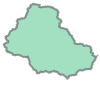

In [64]:
united_polygon

In [65]:
# 생성된 단일 폴리곤의 중심점을 계산합니다.
centroid_point = united_polygon.centroid

In [219]:
df = pd.DataFrame(jg_df['city_s'].value_counts())
#df = df.reset_index()
df

,count
city_s,
약수동,25382
청구동,23383
다산동,23374
황학동,23308
동화동,22564
중림동,22328
신당동,20917
신당5동,20805
광희동,19637


In [7]:
cost_sum_by_city = jg_df.groupby('city_s')['cost'].sum().sort_values(ascending=False)
cost_sum_by_city

city_s
약수동     157497724638
황학동     140289956139
청구동     115371679333
다산동     112676121166
중림동     111812064895
동화동     107917564068
신당동      83364730515
신당5동     77537516775
광희동      74871313654
회현동      73736342886
명동       72046522541
소공동      64666037954
필동       44596316596
장충동      37172142758
을지로동     30264878129
Name: cost, dtype: int64

In [8]:
dict(zip(cost_sum_by_city.index, cost_sum_by_city.values))

{'약수동': 157497724638,
 '황학동': 140289956139,
 '청구동': 115371679333,
 '다산동': 112676121166,
 '중림동': 111812064895,
 '동화동': 107917564068,
 '신당동': 83364730515,
 '신당5동': 77537516775,
 '광희동': 74871313654,
 '회현동': 73736342886,
 '명동': 72046522541,
 '소공동': 64666037954,
 '필동': 44596316596,
 '장충동': 37172142758,
 '을지로동': 30264878129}

In [6]:
# km data preprocessing
def exc_age(age):
    age = age.split(".")[-1].split("대")[0]
    try:
        return "60+" if int(age) >= 60 else age
    except:
        return age
km_data = pd.read_csv("dataset/국민카드.csv", encoding='cp949')
km_data = km_data[~km_data['표준산업세세분류코드'].isna()]
km_data['표준산업세세분류코드'] = km_data['표준산업세세분류코드'].astype(int).astype(str)
km_data['표준산업세세분류코드'] = km_data['표준산업세세분류코드'].apply(lambda x : x[:3])
km_data['STD_TOBZ_M_C'] = km_data['표준산업세세분류코드'].apply(lambda x : x[:2])
km_data['기준년월'] = pd.to_datetime(km_data['기준년월'], format='%Y%m')
km_data['연령대'] = km_data['연령대'].apply(exc_age)
km_data['company'] = '국민'
km_data.columns = ['date', 'city_l', 'city_m', 'city_s', 'sex', 'age', 'code_s_name', 'code_s', 'cost', 'case', 'client', 'code_m', 'company']
km_data = km_data[['date', 'city_l', 'city_m', 'city_s', 'sex', 'age', 'company', 'code_m', 'code_s', 'cost', 'case']]
km_data['case'] = km_data['case'].astype(int)

# sh data preprocessing
city_l_dic = {'전남':'전라남도', '경기':'경기도', '서울':'서울특별시'}
sex_dic = {'F':'여성', 'M':'남성'}
sh_data = pd.read_csv("dataset/신한카드.csv")
sh_data['MGPO_NM_HOM'] = sh_data['MGPO_NM_HOM'].map(city_l_dic)
sh_data['SEX_C'] = sh_data['SEX_C'].map(sex_dic)
sh_data['SL_CRI_YM'] = pd.to_datetime(sh_data['SL_CRI_YM'], format='%Y%m')
sh_data['STD_TOBZ_M_C'] = sh_data['STD_TOBZ_M_C'].astype(str)
sh_data['company'] = '신한'
sh_data = sh_data[['SL_CRI_YM', 'MGPO_NM_HOM', 'SGG_NM_HOM', 'NASD_NM_HOM', 'SEX_C', 'AGE_G5_C', 'company', 'STD_TOBZ_M_C', 'STD_TOBZ_L_C','AMT', 'CNT']]
sh_data.columns = ['date', 'city_l', 'city_m', 'city_s', 'sex', 'age', 'company', 'code_m', 'code_s', 'cost', 'case']
sh_data['case'] = sh_data['case'].apply(lambda x : int(x) if x.isdigit() else 0)

# ss data preprocessing
def exc_age(age):
    return "60+" if int(age) >= 60 else age      
ss_data = pd.read_csv("dataset/삼성카드.csv")
ss_data['표준업종분류코드_중분류'] = ss_data['표준업종분류코드_중분류'].astype(str)
ss_data['거주지_광역시도'] = ss_data['거주지_광역시도'].map(city_l_dic)
ss_data['성별'] = ss_data['성별'].map(sex_dic)
ss_data['이용기준년월'] = pd.to_datetime(ss_data['이용기준년월'], format='%Y%m')
ss_data['연령대'] = ss_data['연령대'].apply(exc_age)
ss_data['company'] = '삼성'
ss_data = ss_data[['이용기준년월', '거주지_광역시도', '거주지_시군구', '거주지_행정동', '성별', '연령대', 'company', '표준업종분류코드_중분류', '표준업종분류코드_소분류','이용금액', '이용건수']]
ss_data.columns = ['date', 'city_l', 'city_m', 'city_s', 'sex', 'age', 'company', 'code_m', 'code_s', 'cost', 'case']
ss_data['case'] = ss_data['case'].astype(int)

# data concat
con_df = pd.concat([km_data, sh_data, ss_data]).reset_index(drop=True) # 3사 데이터 통합
con_df = con_df.drop_duplicates()
jg_df = con_df[con_df['city_m']=='중구'].reset_index(drop=True) # 중구 data만 filtering
ddc_df = con_df[con_df['city_m']=='동두천시'].reset_index(drop=True) # 동두천시 data만 filtering
nj_df = con_df[con_df['city_m']=='나주시'].reset_index(drop=True) # 나주시 data만 filtering

In [7]:
jg_df.to_csv("jg_df.csv", index=False)
ddc_df.to_csv("ddc_df.csv", index=False)
nj_df.to_csv("nj_df.csv", index=False)

In [6]:
# data concat
jg_df

,date,city_l,city_m,city_s,sex,age,company,code_m,code_s,cost,case
0,2023-04-01,서울특별시,중구,다산동,여성,50,국민,56,561,24370810,683
1,2023-05-01,서울특별시,중구,약수동,남성,60+,국민,59,591,20000,3
2,2023-08-01,서울특별시,중구,신당5동,남성,60+,국민,47,478,129200,3
3,2023-03-01,서울특별시,중구,명동,여성,40,국민,56,561,407250,27
4,2023-11-01,서울특별시,중구,다산동,남성,60+,국민,47,474,696940,8
...,...,...,...,...,...,...,...,...,...,...,...
302084,2022-12-01,서울특별시,중구,명동,남성,30,삼성,90,902,32000,3
302085,2023-07-01,서울특별시,중구,다산동,남성,40,삼성,90,902,29000,2
302086,2023-01-01,서울특별시,중구,소공동,여성,30,삼성,90,902,31000,2
302087,2023-03-01,서울특별시,중구,중림동,남성,40,삼성,90,902,137000,13


In [20]:
jg_df[jg_df['date']=='2023-04-01']

,date,city_l,city_m,city_s,sex,age,company,code_m,code_s,cost,case
0,2023-04-01,서울특별시,중구,다산동,여성,50,국민,56,561,24370810,683
18,2023-04-01,서울특별시,중구,신당동,여성,60+,국민,47,479,8726128,160
19,2023-04-01,서울특별시,중구,다산동,여성,10,국민,49,492,457400,44
24,2023-04-01,서울특별시,중구,필동,남성,20,국민,47,476,785780,7
26,2023-04-01,서울특별시,중구,다산동,남성,20,국민,75,751,133630,18
...,...,...,...,...,...,...,...,...,...,...,...
302001,2023-04-01,서울특별시,중구,신당5동,남성,20,삼성,47,476,136000,4
302017,2023-04-01,서울특별시,중구,소공동,여성,50,삼성,47,473,203000,9
302032,2023-04-01,서울특별시,중구,회현동,남성,60+,삼성,47,473,386000,8
302049,2023-04-01,서울특별시,중구,약수동,남성,30,삼성,46,466,6000,2


In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=jg_df['city_s'], x=jg_df['age'], y=jg_df['cost'])])
fig.update_layout(title='Mt Bruno Elevation', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [7]:
jg_df[jg_df['date']=='2023-04-01']

,date,city_l,city_m,city_s,sex,age,company,code_m,code_s,cost,case
0,2023-04-01,서울특별시,중구,다산동,여성,50,국민,56,561,24370810,683
18,2023-04-01,서울특별시,중구,신당동,여성,60+,국민,47,479,8726128,160
19,2023-04-01,서울특별시,중구,다산동,여성,10,국민,49,492,457400,44
24,2023-04-01,서울특별시,중구,필동,남성,20,국민,47,476,785780,7
26,2023-04-01,서울특별시,중구,다산동,남성,20,국민,75,751,133630,18
...,...,...,...,...,...,...,...,...,...,...,...
302001,2023-04-01,서울특별시,중구,신당5동,남성,20,삼성,47,476,136000,4
302017,2023-04-01,서울특별시,중구,소공동,여성,50,삼성,47,473,203000,9
302032,2023-04-01,서울특별시,중구,회현동,남성,60+,삼성,47,473,386000,8
302049,2023-04-01,서울특별시,중구,약수동,남성,30,삼성,46,466,6000,2


In [7]:
codem_count = jg_df['code_m'].value_counts()
codem_count

code_m
47    92135
56    29457
49    18603
91    15428
96    15058
86    13981
61    10324
73     9263
65     8382
52     7929
85     7860
95     7384
55     6356
84     5960
75     5608
68     5134
46     4403
90     4361
51     3903
94     3098
59     2892
33     2876
45     2738
66     2159
18     2051
76     2004
62     1956
10     1805
71     1752
29     1511
35     1308
50      984
87      731
21      698
60      560
42      467
74      349
58      323
70      131
34       68
41       58
14       37
30        4
Name: count, dtype: int64

In [6]:
jg_count_dic = dict(zip(jg_df['code_m'].value_counts().index,jg_df['code_m'].value_counts().values))
jg_std = pd.DataFrame({'표준산업분류코드':sorted(jg_df['code_m'].unique())})
jg_std['표준산업분류(중)'] = jg_std['표준산업분류코드'].map(STD_TOBZ_M_dic)
jg_std['데이터건수'] = jg_std['표준산업분류코드'].map(jg_count_dic)
jg_std = jg_std.sort_values(by='데이터건수').reset_index(drop=True)
jg_std

,표준산업분류코드,표준산업분류(중),데이터건수
0,30,자동차 및 트레일러 제조업,4
1,14,의복 의복 액세서리 및 모피제품 제조업,37
2,41,종합 건설업,58
3,34,산업용 기계 및 장비 수리업,68
4,70,연구개발업,131
5,58,출판업,323
6,74,사업시설 관리 및 조경 서비스업,349
7,42,전문직별 공사업,467
8,60,방송업,560
9,21,의료용 물질 및 의약품 제조업,698


In [ ]:
jg_std

In [ ]:
fig = px.bar(
    x=jg_std['데이터건수'],
    y=jg_std['표준산업분류(중)'],
    color=jg_std['표준산업분류(중)'],
    color_continuous_scale='agsunset'
)

# 레이아웃 업데이트
fig.update_layout(
    xaxis_title='Counts',
    yaxis_title='Standard Industry',
    title='Number of Standard Industry',
    margin=dict(l=270), 
    template='plotly_dark',  # 사용할 템플릿
    font=dict(
        family='Arial, sans-serif',  # 사용할 폰트 설정
        size=12,  # 폰트 크기 설정
    ),
)
# 그림을 보여주기
fig.show()